In [7]:
from collect_data_gen import create_dataloader
from pstd.sd.diffusion import Diffusion
from vae import VAE
from pipeline_gen import generate,rescale
import os
import torch

from matplotlib import pyplot as plt

In [8]:
# Константы
DATASET_FOLDER = 'game_images_dataset'  # Папка для хранения данных
DATASET_SIZE = 1000  # Количество изображений в датасете
SEQUENCE_LENGTH = 20  # Длина последовательности
IMAGE_HEIGHT = 240  # Установите нужные размеры для изображений
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3
DATASET_FILENAME = 'game_dataset_gen.npy'  # Имя файла для хранения всех изображений и действий
BATCH_SIZE = 1  # Размер батча для DataLoader

In [9]:
dataloder = create_dataloader(os.path.join(DATASET_FOLDER, DATASET_FILENAME),batch_size=BATCH_SIZE,shuffle=True)
dataset = dataloder.dataset

In [10]:
vae = VAE()

vae.load_state_dict(torch.load('vae_model.pth',map_location='cpu'))

C:\Users\Skoolz\AppData\Local\Temp\ipykernel_888\1513817619.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('vae_model.pth',map_location='

<All keys matched successfully>

In [11]:
diffusion = Diffusion(seq_len=20,context_space=8)

diffusion.load_state_dict(torch.load('diffusion_model.pth',map_location='cpu'))

C:\Users\Skoolz\AppData\Local\Temp\ipykernel_888\2789041022.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion.load_state_dict(torch.load('diffusion_model.pth',ma

<All keys matched successfully>

In [12]:
with torch.no_grad():
    diffusion.eval()
    vae.eval()
    for b in dataloder:
        images,actions = b
    
        batch_size,seq_len,channels,height,width = images.shape
    
        target_images = images[:,-1] #(b,4,32,32)
    
        target_images = vae.decode(target_images)
    
        target_images = rescale(target_images, (-1, 1), (0, 255), clamp=True)
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        target_images = target_images.permute(0, 2, 3, 1)
        target_images = target_images.to("cpu", torch.uint8).numpy()
    
        print('target was reconstructed')
        
        images = images[:,:-1] #(b,seq_len-1,4,32,32)
    
        images = images.view(batch_size,(seq_len-1)*channels,height,width) #(b,(seq_len-1)*4,32,32)
    
        output,_ = generate(actions,images,diffusion=diffusion,vae=vae,n_inference_steps=10)
    
        break

torch.Size([1, 4, 32, 32])
target was reconstructed


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


torch.Size([1, 4, 32, 32])


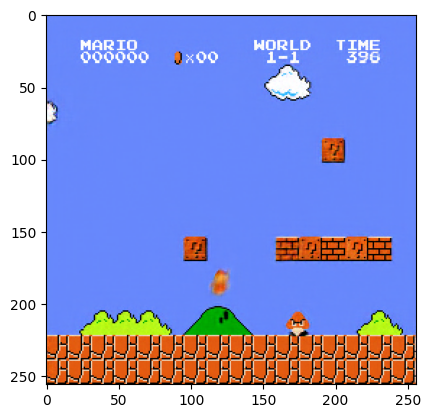

In [13]:
plt.imshow(output[0])

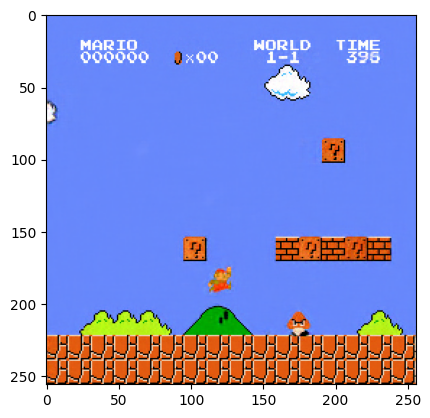

In [14]:
plt.imshow(target_images[0])